In [107]:
##########################################################################################
#################################### IMPORT LIBRARIES ####################################
##########################################################################################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2

The following cell is the only piece of code that needs user input. <br>
The steps needed to set up the code according to the user's whishes are as follows:<br>
<br>
1) Replace the given file path with the correct path of your dataset.<br>
<br>
   The file should be a .csv file, arranged in three columns:<br>
   Column named 'Radiocarbon Dates' with the results of your measurement in 14C years BP<br>
   Column named 'Radiocarbon Error' with the errors of your measurement in 14C years BP<br>
   Column named 'Ring Nr' with the ordered spacing of the samples, with the outermost ring (or most recent sample in the sequence) given number 0<br>
   See the provided file 'data_example.csv' as a reference.<br>
<br>
2) Replace the given file path for the calibration curve, if you wish to use a different one. IntCal20 is provided.<br>
<br>
   The calibration curve file should be a .csv file, having at lest the following columns:<br>
   Column named 'year_CE' with the calendar year (positive number for CE, negative number for BCE)<br>
   Column named 'CRA' with the radiocarbon age expressed in 14C years BP<br>
   Column named 'sd_CRA' with the uncertainty of the radiocarbon age expressed in 14C years BP<br>
<br>
3) Enter the range of dates that you want to analyze in the Chi-Squared test. The range 700 CE to 800 CE is given to fit the example data.<br>

In [109]:
############ Load Dataset
df = pd.read_csv('./Data/data_example.csv')                    ####### replace with the path of your dataset!

############ Load IntCal20
intcal20 = pd.read_csv('./Data/IntCal20.csv')                  ####### replace with the path of your reference curve, if needed!

############ Define Test Range for the Chi-Squared Test
test_range = range(700,800)                                    ####### replace with start and end dates of the range you want to test!

In [110]:
#################################################################################################
#################################### CHI SQUARED CALIBRATION ####################################
#################################################################################################

p = 0.05
sample_range = np.arange(2, 51)
chi_table = pd.DataFrame({
    'df': sample_range - 1,
    'chi': chi2.isf(p, sample_range - 1)
}, index=sample_range)

Chi_result = np.zeros(len(test_range))
Year_result = np.zeros(len(test_range))

R = df['Radiocarbon Dates']
delta_R = df['Radiocarbon Error']
r = df['Ring Nr']
C = intcal20['CRA']
delta_C = intcal20['sd_CRA']

for x in test_range:
        for i in range(len(R)):
            diff = x - r[i]
            if diff >0:
                year_idx = diff
            else:
                year_idx = diff-1 # IntCal20 doesn't have year 0!
            numerator = ((R[i]) - (C[intcal20['year_CE'] == year_idx])) ** 2
            denominator = ((delta_R[i]) ** 2 + (delta_C[intcal20['year_CE'] == year_idx]) ** 2)
            Chi_result[x - min(test_range)] += numerator / denominator
        Year_result[x - min(test_range)] = x

min_chi_value = np.min(Chi_result)
mask_min_chi = np.array(Chi_result) == min_chi_value
colors = np.where(mask_min_chi, 'forestgreen', 'dodgerblue')

df_chi = pd.DataFrame({
    'Years': Year_result,
    'Chi': Chi_result,
    'Colour': colors
})

passed_years = Year_result[Chi_result < chi_table['chi'][len(df['Radiocarbon Dates'])]]
passed_years = [int(year) for year in passed_years]
Chi_best_estimate = Year_result[Chi_result==min_chi_value]
best_estimate = int(Chi_best_estimate[0])


print('All the years that passed the \u03C7² test are:')
print(', '.join(f'{year}' for year in passed_years))
print('And the best estimate for the felling date, according to the \u03C7² test is:')
print(f'{best_estimate}')

All the years that passed the χ² test are:
781, 782, 783, 784, 785
And the best estimate for the felling date, according to the χ² test is:
783


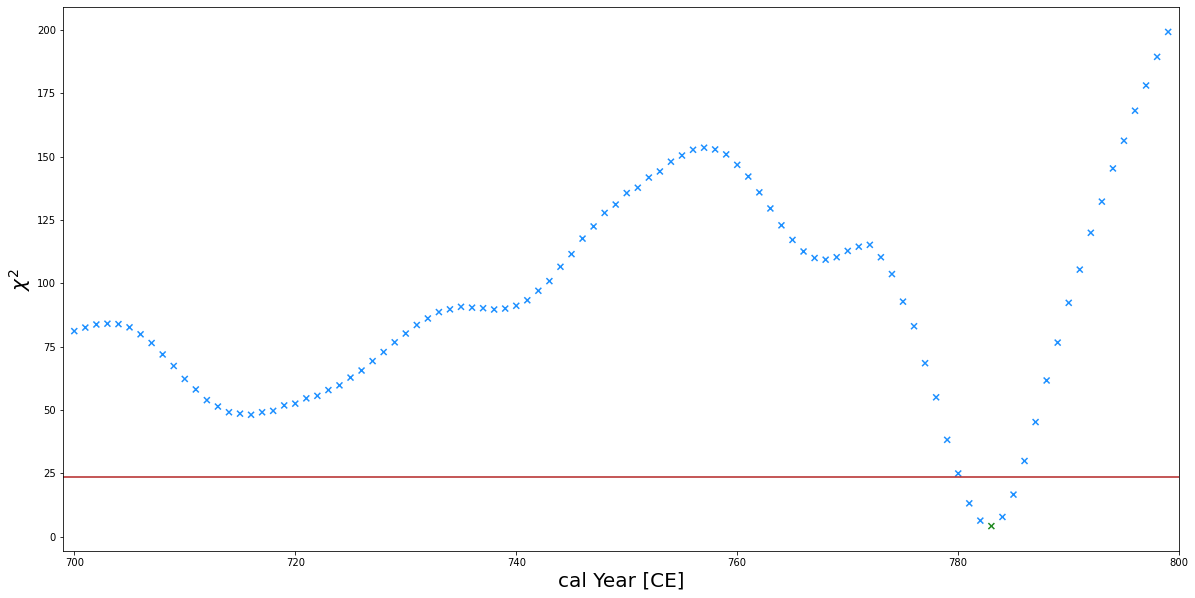

In [111]:
###################################################################################################
####################### PLOT CHI SQUARED RESULTS #######################
###################################################################################################

x = df_chi['Years']
y = df_chi['Chi']
colors = df_chi['Colour']

### PLOT
fig = plt.figure(figsize=(20,10))
ax = plt.subplot(1,1,1)

ax.scatter(x, y, marker='x', color=colors)
ax.hlines(chi_table['chi'][len(df['Radiocarbon Dates'])], min(test_range)-1, max(test_range)+1, color='firebrick')

ax.set_xlim(min(test_range)-1, max(test_range)+1)
ax.set_xlabel('cal Year [CE]', fontsize=20)
ax.set_ylabel('$\chi^2$', fontsize=20)
plt.show()